In [12]:
import os, glob, numpy as np, csv, math
import matplotlib.pyplot as plt
from scipy import signal, fftpack

wrkdir = 'Y:\Projects\DropletJumpWedge\Repos_Data\data'
csv_files = wrkdir+'\\*.csv'
meta_files = wrkdir+'\\*.txt'
trackdata = glob.glob(csv_files)
metadata = glob.glob(meta_files)
n_files = np.size(trackdata)


# Retrieve drop variables

In [13]:
def get_drop_vars(metadata):
    f = open(metadata[0],"r")
    drop_vars = list(csv.reader(f))
    f.close()
    
    
    drop_meta = {}
    for i in range(n_files):
        drop_meta[drop_vars[i+1][0]] = {}
        n_meta = np.size(drop_vars[0][1:])
        for n in range(n_meta):
            drop_meta[drop_vars[i+1][0]][drop_vars[0][n+1].split('_')[0]] = float(drop_vars[i+1][n+1])

    meta = drop_meta
    return meta

meta is a nested dictionary with global key by drop number and sub keys 'Angle', 'Volume', 'ILfront', 'ILback', and 'Scale'

# Retrieve data

In [14]:
def gen_data_repos(wrkdir,csv_files,trackdata,n_files):
    
    total_drop_data = {}
    
    
    for i in range(n_files):
        (location, name) = os.path.split( trackdata[i] )
        
        f = open(trackdata[i],"r")
        drop_data = list(csv.reader(f))
        f.close()
        
        col_names = drop_data[0]
        n_col = np.size(drop_data[0])
        drop_data = np.asarray(drop_data[1:],dtype=float)
        total_drop_data[name[:-4]] = {}
        for j in range(n_col):
            total_drop_data[name[:-4]][col_names[j]] = drop_data[:,j]

    return total_drop_data

# Plot data - raw

In [15]:
def plot_data(data,meta,volumes,location):
    fig = plt.figure(facecolor="white")
    plt.style.use('classic')
    font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 16}
    plt.rc('font',**font)
    
    for key in sorted(data):
        drop_num = key
        if(meta[drop_num]['Volume'] in volumes ):
            if(meta[drop_num]['Volume'] == 0.5):
                color = 'r'
            elif(meta[drop_num]['Volume'] == 1.0):
                color = 'k'
            elif(meta[drop_num]['Volume'] == 2.0):
                color = 'b' 
                
            ax = fig.add_subplot(1,1,1)
            ax.plot(data[drop_num]['time'],data[drop_num][location],c=color,marker='.',linestyle='None',\
                    label=str(meta[drop_num]['Volume'])+'ml '+str( meta[drop_num]['ILback'])+'mm '+drop_num)
            
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            ax.minorticks_on()
            
            ax.legend(bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=12,facecolor="white")
            
            ax.set_xlabel('t (s)',fontsize=18)
            ax.set_ylabel('x (mm)',fontsize=18)
            
            ax.grid(b=True,which='major')
            ax.grid(b=True,which='minor')
    plt.show()

# Filter - spline fitting and velocity evaluation

In [16]:
def filtering_data(data,meta,volumes,angles,location):
    fig1 = plt.figure(facecolor="white")
    fig2 = plt.figure(facecolor="white")
    plt.style.use('classic')
    font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 16}
    plt.rc('font',**font)
    v_norm = {}
    x_max = {}
    
    for key in sorted(meta, key = lambda x: meta[x]['ILback']):
        if(meta[key]['Volume'] in volumes and meta[key]['Angle'] in angles):
            if(meta[key]['Volume'] == 0.5):
                color = 'k'
                style = None
            elif(meta[key]['Volume'] == 1.0):
                color = 'c'
                style = None
            elif(meta[key]['Volume'] == 2.0):
                color = 'b'
                style = None
            
            dat = data[key][location][1:] 
            t = data[key]['time'][1:]
        
            slice_num = 5
            dat_sliced = dat[::slice_num]
            t_sliced = t[::slice_num]
            x_max[key] = max(dat_sliced)
            
            nn = int((np.ceil(np.size(dat_sliced)/2))*2-1)
            nn2 = nn-10
            nn3 = nn2-2
            

            poly_fit = 5
            x1 = signal.savgol_filter(dat_sliced,nn,poly_fit)
            x2 = signal.savgol_filter(x1,nn2,poly_fit)
            x3 = signal.savgol_filter(x2,nn3,poly_fit)
            xf = signal.savgol_filter(x3,slice_num+2,poly_fit)
            #print('nn1='+str(nn)+' nn2='+str(nn2)+' nn3='+str(nn3))

            
            ax = fig1.add_subplot(1,1,1)
            ax.plot(t_sliced,dat_sliced,'o',label=key+' '+str(meta[key]['Volume'])+'ml '+\
                    str(meta[key]['Angle'])+'deg '+str( meta[key]['ILback'])+'mm ')
            ax.plot(t_sliced,xf,c=color,marker=style)

            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            ax.minorticks_on()

            legend1 = ax.legend(bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=12)
            legend1.get_frame().set_facecolor('white')

            ax.set_xlabel('t (s)',fontsize=18)
            ax.set_ylabel('x (mm)',fontsize=18)
            
            ax.grid(b=True,which='major')
            ax.grid(b=True,which='minor')
            
            dxdt_savgol = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_savgol[i] = (xf[i+2]-xf[i])/(2*(t_sliced[i+1]-t_sliced[i]))
                
            
            dxdt_centraldiff = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_centraldiff[i] = (dat_sliced[i+2]-dat_sliced[i])/(2*(t_sliced[i+1]-t_sliced[i]))
                
                
            ax2 = fig2.add_subplot(1,1,1)
            ax2.plot(t_sliced[1:-1],dxdt_centraldiff,'.',marker='o',label=key+' '+str(meta[key]['Volume'])+'ml '\
                     +str(meta[key]['Angle'])+'deg '+str( meta[key]['ILback'])+'mm ')
            ax2.plot(t_sliced[1:-1],dxdt_savgol,c=color,marker=style,label=key+' '+str(meta[key]['Volume'])+'ml '\
                     +str(meta[key]['Angle'])+'deg '+str( meta[key]['ILback'])+'mm ')

            ax2.spines['right'].set_color('none')
            ax2.spines['top'].set_color('none')
            ax2.yaxis.set_ticks_position('left')
            ax2.xaxis.set_ticks_position('bottom')
            ax2.minorticks_on()
            
            legend2 = ax2.legend(bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=12)
            legend2.get_frame().set_facecolor('white')

            ax2.set_xlabel('t (s)',fontsize=18)
            ax2.set_ylabel('v (mm/s)',fontsize=18)

            ax2.grid(b=True,which='major')
            ax2.grid(b=True,which='minor')
            ax2.set_xlim([0,2.1])
#            ax2.set_ylim([0,150])
            
            fig1.savefig('Figures/positions.png',dpi=100,bbox_extra_artists=(legend1,), bbox_inches='tight')
            fig2.savefig('Figures/velocities.png',dpi=100,bbox_extra_artists=(legend2,), bbox_inches='tight')
            
            v_norm[key] = max(dxdt_savgol)
    return v_norm, x_max

# Normalized stuff

In [17]:
def normalized_variables(meta,data):
    xi_norm = {}
    for key in sorted(data):
        xi = meta[key]['ILback']/1000 # m
        V = meta[key]['Volume']*(10**(-6)) # m^3
        alpha = (meta[key]['Angle']/2.)*(math.pi/180.) # rad
        xi_norm[key] = xi*((4*math.pi)/(3*V))**(1/3.)*math.sin(alpha)
        
    return xi_norm   
    

# Run stuff

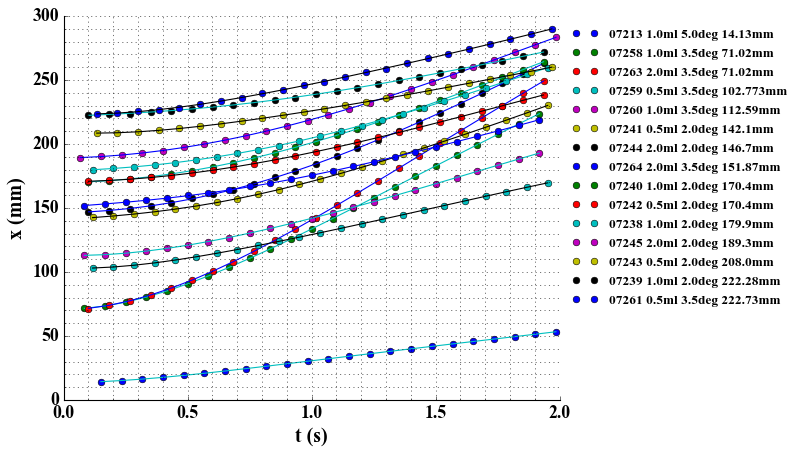

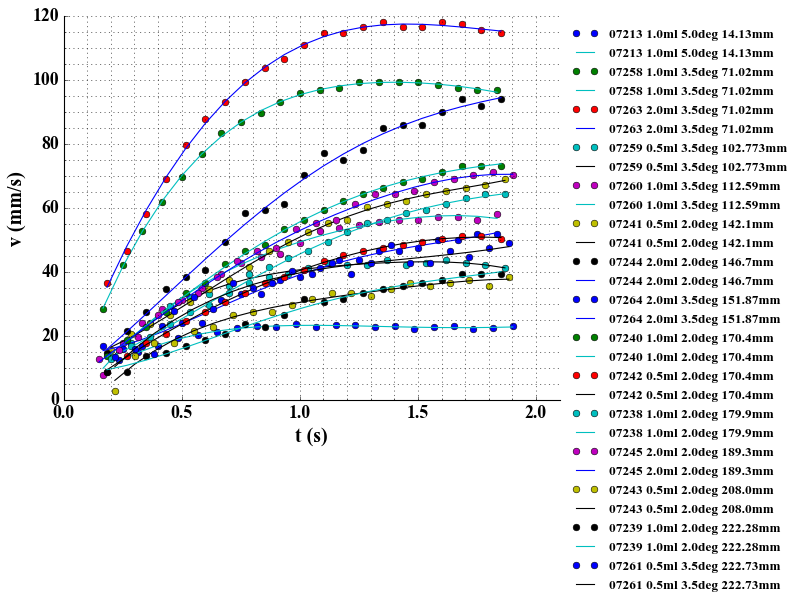

In [18]:
data = gen_data_repos(wrkdir,csv_files,trackdata,n_files)
meta = get_drop_vars(metadata)
location = 'back'
volumes = [0.5,1.0,2.0]
angles= [2.0,3.5,5.0]
data = gen_data_repos(wrkdir,csv_files,trackdata,n_files)
meta = get_drop_vars(metadata)
#plot_data(data,meta,volumes,location)
[v_norm,x_max] = filtering_data(data,meta,volumes,angles,location)
xi_norm = normalized_variables(meta,data)
plt.show()


07213 62.5044499086
07238 26.9413501781
07239 23.5233398049
07240 25.6636752416
07241 18.4225755755
07242 15.5350866959
07243 7.77020376306
07244 41.2746606267
07245 36.7420989421
07258
07259
07260 4.95691176148
07261
07263 2.64075607666
07264 14.4769247539


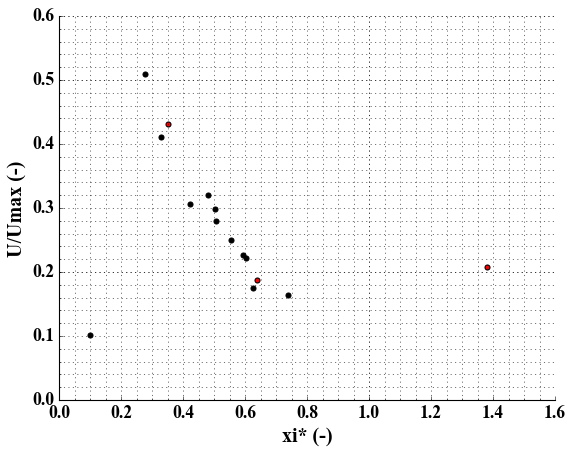

In [19]:
v_max = ((4*0.072*9.81)/1000)**(1/4.)*1000
fig1 = plt.figure(facecolor="white")
plt.style.use('classic')
font = {'family' : 'Times New Roman',
            'weight' : 'bold',
            'size'   : 16}
plt.rc('font',**font)
for key in xi_norm:
    R = ((3000*meta[key]['Volume'])/(4*math.pi))**(1/3)
    sin_angl = math.sin((meta[key]['Angle']/2)*(math.pi/180))
    x_max_theo = R/sin_angl
    if x_max[key]>x_max_theo:
        color = 'r'
        print(key)
    else:
        print(key+' '+str(((x_max_theo-x_max[key])/x_max_theo)*100))
        color = 'k'
    ax = fig1.add_subplot(1,1,1)        
    ax.scatter(xi_norm[key],v_norm[key]/v_max,c=color)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.minorticks_on()

    #legend1 = ax.legend(bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=12)
    #legend1.get_frame().set_facecolor('white')

    ax.set_xlabel('xi* (-)',fontsize=18)
    ax.set_ylabel('U/Umax (-)',fontsize=18)

    ax.grid(b=True,which='major')
    ax.grid(b=True,which='minor')
plt.show()

In [20]:
v_norm


{'07213': 23.444272768025169,
 '07238': 64.580092961550363,
 '07239': 40.188809932618106,
 '07240': 73.903158345845497,
 '07241': 68.736671883349374,
 '07242': 51.01888798449059,
 '07243': 37.861641425377456,
 '07244': 94.593125210043254,
 '07245': 70.638386004118317,
 '07258': 99.411615594840541,
 '07259': 43.306758796725155,
 '07260': 57.743740155178877,
 '07261': 48.028335247717209,
 '07263': 117.59212278211363,
 '07264': 52.3920250557088}

In [21]:
xi_norm

{'07213': 0.09935382538000562,
 '07238': 0.5061151662047212,
 '07239': 0.6253434082489463,
 '07240': 0.4793886843873513,
 '07241': 0.5036810341213667,
 '07242': 0.6039918945410336,
 '07243': 0.7372671013176937,
 '07244': 0.32757064069382646,
 '07245': 0.42269340343109313,
 '07258': 0.34961610250636815,
 '07259': 0.6374309183589766,
 '07260': 0.5542562233341592,
 '07261': 1.3814424843693855,
 '07263': 0.27749048445181534,
 '07264': 0.5933889027555224}